In [138]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [139]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
directory = 'Alzheimer_s Dataset/'

In [3]:
test_directory = 'Alzheimer_s Dataset/test/'
train_directory = 'Alzheimer_s Dataset/train/'

In [35]:
data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [96]:
type(data_genorator)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [36]:
data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

Found 4098 images belonging to 4 classes.


In [37]:
data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

Found 1023 images belonging to 4 classes.


In [38]:
data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

Found 1279 images belonging to 4 classes.


In [39]:
train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

In [143]:
#Augmeneting minority classes

#create image generators
hflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
vflip = ImageDataGenerator(rescale=1./255,vertical_flip=True)
hshift = ImageDataGenerator(rescale=1./255,width_shift_range=(-40,40))
vshift = ImageDataGenerator(rescale=1./255,height_shift_range=(-40,40))
rotation = ImageDataGenerator(rescale=1./255,rotation_range=90)
shear = ImageDataGenerator(rescale=1./255,shear_range=45)
hvflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True)
bright = ImageDataGenerator(rescale=1./255,brightness_range=(.2,1))
bright_rot = ImageDataGenerator(rescale=1./255,brightness_range=(.2,1),rotation_range=90)


augmentors = [hflip,vflip,hshift,vshift,rotation,shear,hvflip,bright,bright_rot]

#iterate through augmentors and generate augmented image sets
mild_augmented = []
mod_augmented = []

for augmentor in augmentors[:2]:

    aug_mild = augmentor.flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['MildDemented'])
    
    mild_augmented.append(aug_mild)

for augmentor in augmentors:    

    aug_moderate = augmentor.flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['ModerateDemented'])
    
    mod_augmented.append(aug_moderate)
    

#extract image matricies from generators and separate out images matricies from labels
data_mild_aug = [next(mild) for mild in mild_augmented]  
data_mod_aug = [next(mod) for mod in mod_augmented]

mild_aug_images = [images[0] for images in data_mild_aug]
mod_aug_images = [images[0] for images in data_mod_aug]

Found 717 images belonging to 1 classes.
Found 717 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.


In [144]:
#concat all matricies together
concat_mild_images = np.vstack(mild_aug_images)
concat_mod_images = np.vstack(mod_aug_images)

In [145]:
#create label matricies 
concat_mild_labels = np.array([[1.,0.,0.,0.] for i in range(len(concat_mild_images))])
concat_mod_labels = np.array([[0.,1.,0.,0.] for i in range(len(concat_mod_images))])

In [146]:
#concat back to original training data
train_images_aug = np.concatenate((train_images,concat_mild_images,concat_mod_images))
train_labels_aug = np.concatenate((train_labels,concat_mild_labels,concat_mod_labels))

In [161]:
import pickle

In [163]:
pickle_out = open('train_aug.pickle','wb')
pickle.dump((train_images_aug,train_labels_aug),pickle_out)
pickle_out.close()


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

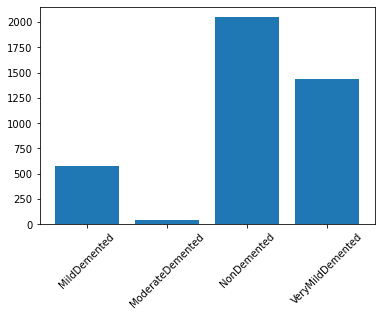

In [147]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels))
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

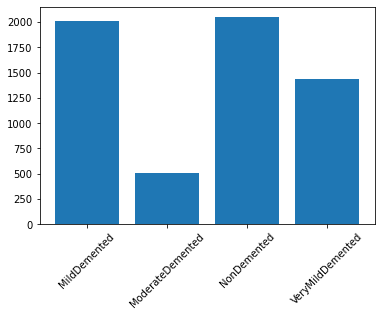

In [148]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels_aug))
plt.xticks(rotation=45)

In [132]:
def get_label(array):
    if array[0] ==1:
        return 0
    elif array[1] ==1:
        return 1
    elif array[2] ==1:
        return 2
    elif array[3] ==1:
        return 3

In [133]:
train_label_names = np.apply_along_axis(get_label,1,train_labels)

test_label_names = np.apply_along_axis(get_label,1,test_labels)

valid_label_names = np.apply_along_axis(get_label,1,valid_labels)

In [156]:
x_train = train_images.reshape(4098,150528)

x_train_aug = train_images_aug.reshape(6000,150528)

x_test = test_images.reshape(1279,150528)

x_valid = valid_images.reshape(1023,150528)

## First Vanilla Model

In [140]:
batch_size = 15
num_classes = 4
epochs = 30


model = Sequential()

model.add(Dense(30, activation='relu',input_shape=(150528,),use_bias=True,bias_initializer='zeros'))

model.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy',Recall()])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

history = model.fit(x_train, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks= [early_stop],
                    validation_data=(x_valid, valid_labels))
score = model.evaluate(x_test, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[2])
print('Test Accuracy', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                4515870   
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 124       
Total params: 4,516,924
Trainable params: 4,516,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
274/274 [==============================] - 9s 33ms/step - loss: 1.8343 - accuracy: 0.5178 - recall_2: 0.4907 - val_loss: 1.6131 - val_accuracy: 0.4027 - val_recall_2: 0.3705
Epoch 2/30
274/274 [==============================] - 7s 27ms/step - loss: 0.9886 - accuracy: 0.6013 - recall_2: 0.5544 - val_loss: 2.1112 - val_accuracy: 0.4946 - val_recall_2: 0.4858
Epoc

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

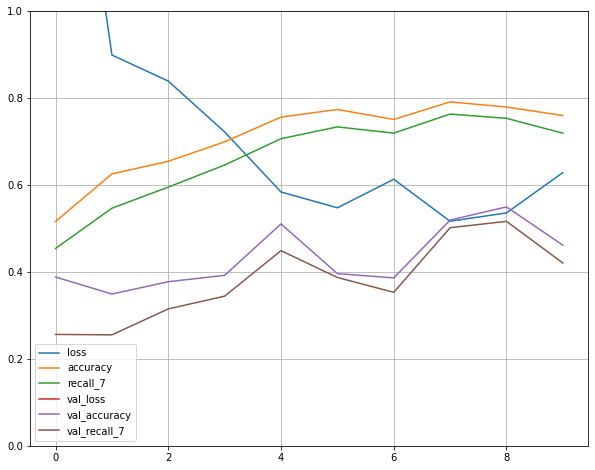

In [184]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [151]:
history_df

,loss,accuracy,recall_2,val_loss,val_accuracy,val_recall_2
0,1.834350,0.517814,0.490727,1.613069,0.402737,0.370479
1,0.988574,0.601269,0.554417,2.111170,0.494624,0.485826
2,0.922002,0.616886,0.570522,1.251529,0.289345,0.183773
3,0.802703,0.653001,0.578087,1.112704,0.461388,0.395894
4,0.913175,0.548804,0.407028,1.090681,0.500489,0.017595
5,0.975530,0.503172,0.346022,1.048733,0.494624,0.399805
6,0.939547,0.516837,0.382382,1.012090,0.499511,0.365591
7,0.908984,0.533919,0.371645,1.010552,0.530792,0.363636
8,0.874844,0.552221,0.372865,1.025409,0.439883,0.284457
9,0.862448,0.565642,0.369204,1.042263,0.464321,0.236559


In [180]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [181]:
test_labels.argmax(axis=1)

array([2, 3, 0, ..., 0, 3, 3])

In [182]:
y_pred = model.predict_classes(x_test)


Confusion Matrix, without normalization
[[ 46   0  94  39]
 [  5   0   4   3]
 [ 17   0 573  50]
 [ 51   0 297 100]]


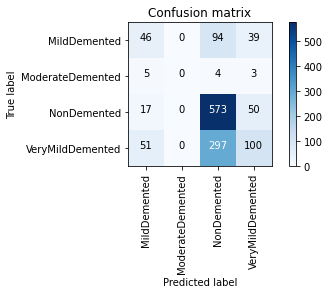

In [183]:
import itertools
confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices)

## Vanilla Model with Augmented Images

In [153]:
x_train_aug.shape

(6717, 150528)

In [154]:
train_labels_aug.shape

(6000, 4)

In [160]:
batch_size = 15
num_classes = 4
epochs = 40


model = Sequential()

model.add(Dense(30, activation='relu',input_shape=(150528,),use_bias=True,bias_initializer='zeros'))

model.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy',Recall()])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

history = model.fit(x_train_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks= [early_stop],
                    validation_data=(x_valid, valid_labels))
score = model.evaluate(x_test, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[2])
print('Test Accuracy', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 30)                4515870   
_________________________________________________________________
dense_22 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 124       
Total params: 4,516,924
Trainable params: 4,516,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
400/400 [==============================] - 11s 27ms/step - loss: 1.8022 - accuracy: 0.5158 - recall_7: 0.4538 - val_loss: 1.3430 - val_accuracy: 0.3881 - val_recall_7: 0.2561
Epoch 2/40
400/400 [==============================] - 11s 27ms/step - loss: 0.8985 - accuracy: 0.6252 - recall_7: 0.5463 - val_loss: 1.5924 - val_accuracy: 0.3490 - val_recall_7: 0.2551
Ep